In [1]:
from sctoolbox.utilities import bgcolor

# Embedding and clustering
<hr style="border:2px solid black"> </hr>

<h1><center>⬐ Fill in input data here ⬎</center></h1>

In [2]:
%bgcolor PowderBlue

############### DEFINING RUN ID ######################################
run_id = "Run1"

############### DEFINING INPUTS ######################################
#path_imput="/mnt/agnerds/loosolab_SC_RNA_framework/raw_data" # This is the directory where the preprocessed data is located

############### DEFINING THE STAGE OF ANALYSIS ########################
is_it_the_final_run = "No" # Set to Yes if this is the final running before send to colaborators

#### Number of PCs
n_pcs = None # This overwrites the automatic selection of PCs. Set to None to set number of PCs automatically

search_umap_parameters = True

############### CLUSTERING DATA ######################################
n_neighbors = 15 # Set the number of nearest neighbors to be used in clustering. Default=15

dist_range = (0.1, 1, 0.2) # Set min_dist range for umap
spread_range = (1.0, 3.5, 0.5) # Set spread range for umap

search_clustering_parameters = True
clustering_method = "leiden" # leiden/louvain

############### DEFINING COLORS AND FIGURE PATH #####################
color_list = ['green', 'red', 'blue', 'pink', 'chartreuse', 'gray', 'yellow', 'brown', 'purple', 'orange', 'wheat', 'lightseagreen', 'cyan', 'khaki', 'cornflowerblue', 'olive', 'gainsboro', 'darkmagenta', 'slategray', 'ivory', 'darkorchid', 'papayawhip', 'paleturquoise', 'oldlace', 'orangered', 'lavenderblush', 'gold', 'seagreen', 'deepskyblue', 'lavender', 'peru', 'silver', 'midnightblue', 'antiquewhite', 'blanchedalmond', 'firebrick', 'greenyellow', 'thistle', 'powderblue', 'darkseagreen', 'darkolivegreen', 'moccasin', 'olivedrab', 'mediumseagreen', 'lightgray', 'darkgreen', 'tan', 'yellowgreen', 'peachpuff', 'cornsilk', 'darkblue', 'violet', 'cadetblue', 'palegoldenrod', 'darkturquoise', 'sienna', 'mediumorchid', 'springgreen', 'darkgoldenrod', 'magenta', 'steelblue', 'navy', 'lightgoldenrodyellow', 'saddlebrown', 'aliceblue', 'beige', 'hotpink', 'aquamarine', 'tomato', 'darksalmon', 'navajowhite', 'lawngreen', 'lightsteelblue', 'crimson', 'mediumturquoise', 'mistyrose', 'lightcoral', 'mediumaquamarine', 'mediumblue', 'darkred', 'lightskyblue', 'mediumspringgreen', 'darkviolet', 'royalblue', 'seashell', 'azure', 'lightgreen', 'fuchsia', 'floralwhite', 'mintcream', 'lightcyan', 'bisque', 'deeppink', 'limegreen', 'lightblue', 'darkkhaki', 'maroon', 'aqua', 'lightyellow', 'plum', 'indianred', 'linen', 'honeydew', 'burlywood', 'goldenrod', 'mediumslateblue', 'lime', 'lightslategray', 'forestgreen', 'dimgray', 'lemonchiffon', 'darkgray', 'dodgerblue', 'darkcyan', 'orchid', 'blueviolet', 'mediumpurple', 'darkslategray', 'turquoise', 'salmon', 'lightsalmon', 'coral', 'lightpink', 'slateblue', 'darkslateblue', 'white', 'sandybrown', 'chocolate', 'teal', 'mediumvioletred', 'skyblue', 'snow', 'palegreen', 'ghostwhite', 'indigo', 'rosybrown', 'palevioletred', 'darkorange', 'whitesmoke']

<hr style="border:2px solid black"> </hr>

## Loading packages

In [7]:
import os
from os import path
import scanpy as sc
from kneed import KneeLocator
import matplotlib.pyplot as plt

import sctoolbox.utilities as utils
import sctoolbox.analyser as analyser
import sctoolbox.plotting as pl

## Load anndata from previous notebook

In [8]:
adata = utils.load_anndata(is_from_previous_note=True, which_notebook=3)
display(adata)

AnnData object with n_obs × n_vars = 2738 × 21128
    obs: 'orig.ident', 'chamber', 'donor', 'batch', 'sample', 'celltype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_is_ribo', 'log1p_total_counts_is_ribo', 'pct_counts_is_ribo', 'total_counts_is_mito', 'log1p_total_counts_is_mito', 'pct_counts_is_mito', 'total_counts_is_gender', 'log1p_total_counts_is_gender', 'pct_counts_is_gender', 'predicted_sex', 'leiden', 'LISI_score_X_pca', 'LISI_score_X_umap'
    var: 'is_ribo', 'is_mito', 'cellcycle', 'is_gender', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'batch_colors', 'color_set', 'hvg', 'infoprocess', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_scanorama', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [9]:
condition_column = adata.uns['infoprocess']['data_to_evaluate']

In [10]:
figure_path = adata.uns["infoprocess"]["Anndata_path"] + "/"

## Subset number of PCs 
 Find initial neighbors and calculate differential expression
- NOTE: trim: Set to 0 to skip default 10. trims neighbours of cells can help to identify individual populations. Lower value more population but more batch
- NOTE: n_pcs: number of pca dimensions

In [11]:
if n_pcs is None:
    n_pcs = analyser.define_PC(adata)

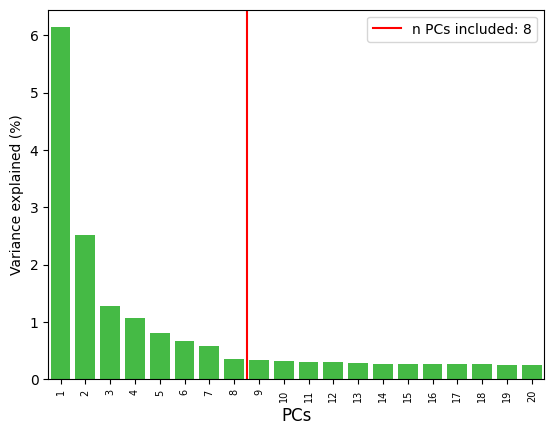

In [12]:
ax = pl.plot_pca_variance(adata)
ax.axvline(n_pcs-0.5, color="red", label=f"n PCs included: {n_pcs}")
plt.legend()
utils.save_figure(figure_path + "PC_selection.pdf")

In [13]:
# Subset PCA
analyser.subset_PCA(adata, n_pcs)

## Rerun neighbors

In [14]:
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs)

## Calculate UMAP and find best setting

- NOTE: min_dist: distances between points to make the plot looks more 'clustered'
- NOTE: spread: The effective scale of embedded points value be de default is 1

Plotting umap for spread=2.0 and dist=0.1 (1/8)
Plotting umap for spread=2.0 and dist=0.2 (2/8)
Plotting umap for spread=2.0 and dist=0.3 (3/8)
Plotting umap for spread=2.0 and dist=0.4 (4/8)
Plotting umap for spread=2.5 and dist=0.1 (5/8)
Plotting umap for spread=2.5 and dist=0.2 (6/8)
Plotting umap for spread=2.5 and dist=0.3 (7/8)
Plotting umap for spread=2.5 and dist=0.4 (8/8)


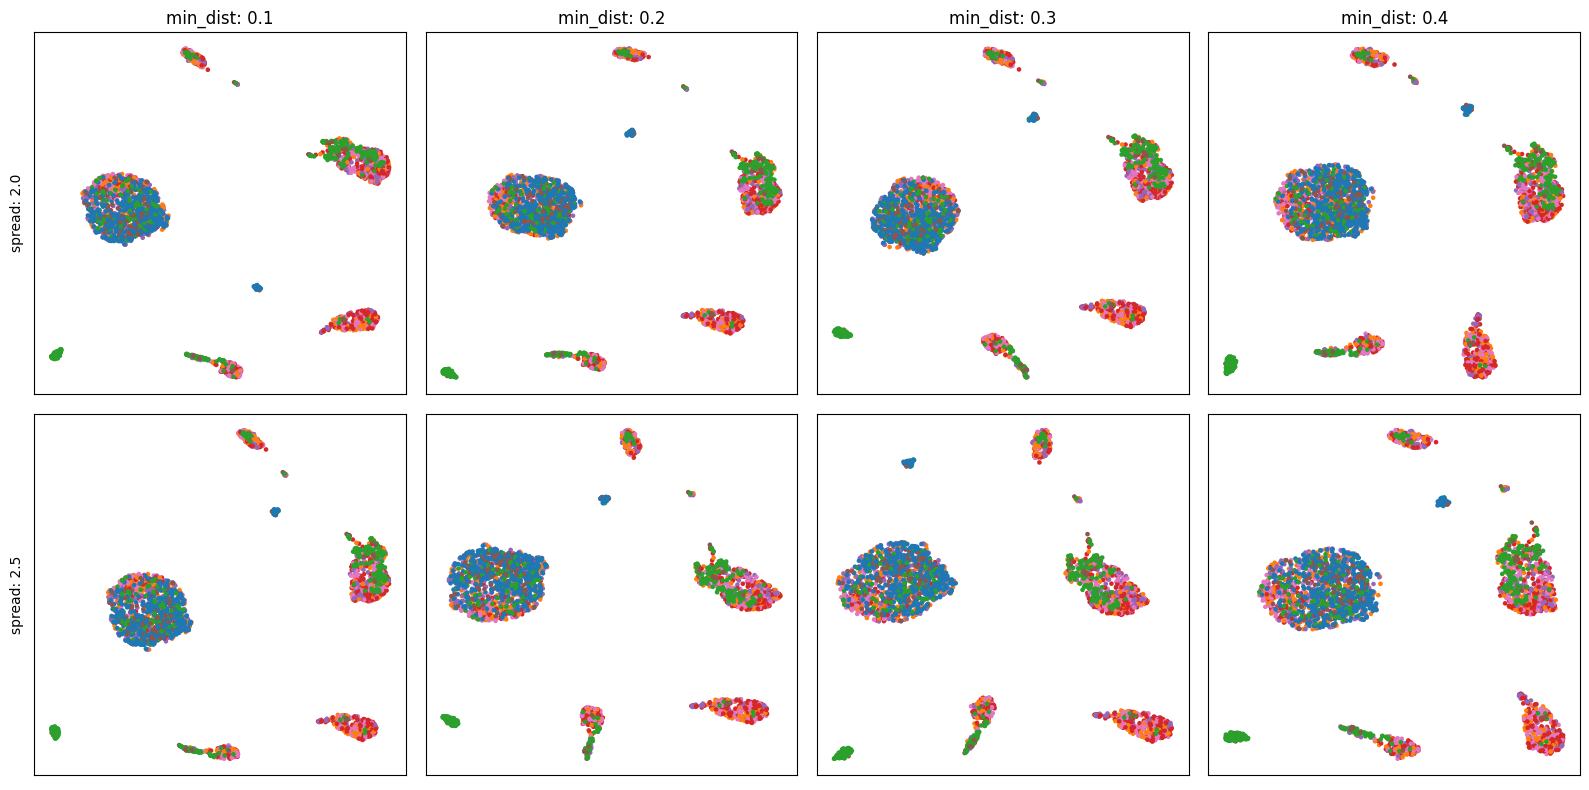

In [15]:
if search_umap_parameters:
    pl.search_umap_parameters(adata,dist_range=dist_range,
                              spread_range=spread_range,
                              metacol=condition_column,
                              save=figure_path + "UMAP_parameter_search.pdf")

In [3]:
%bgcolor PowderBlue

# Final choice of spread / dist
min_dist = 0.4
spread = 2.5

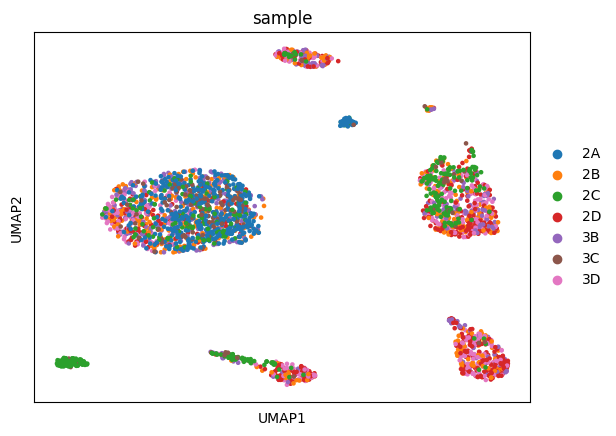

In [17]:
# Plot final UMAP with quality measures
sc.tl.umap(adata, min_dist=min_dist, spread=spread)
sc.pl.umap(adata, color=condition_column)

/home/mbentse/.conda/envs/sctoolbox/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/mbentse/.conda/envs/sctoolbox/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/mbentse/.conda/envs/sctoolbox/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/mbentse/.conda/envs/sctoolbox/lib/python3.10/site-packages/scanpy/p

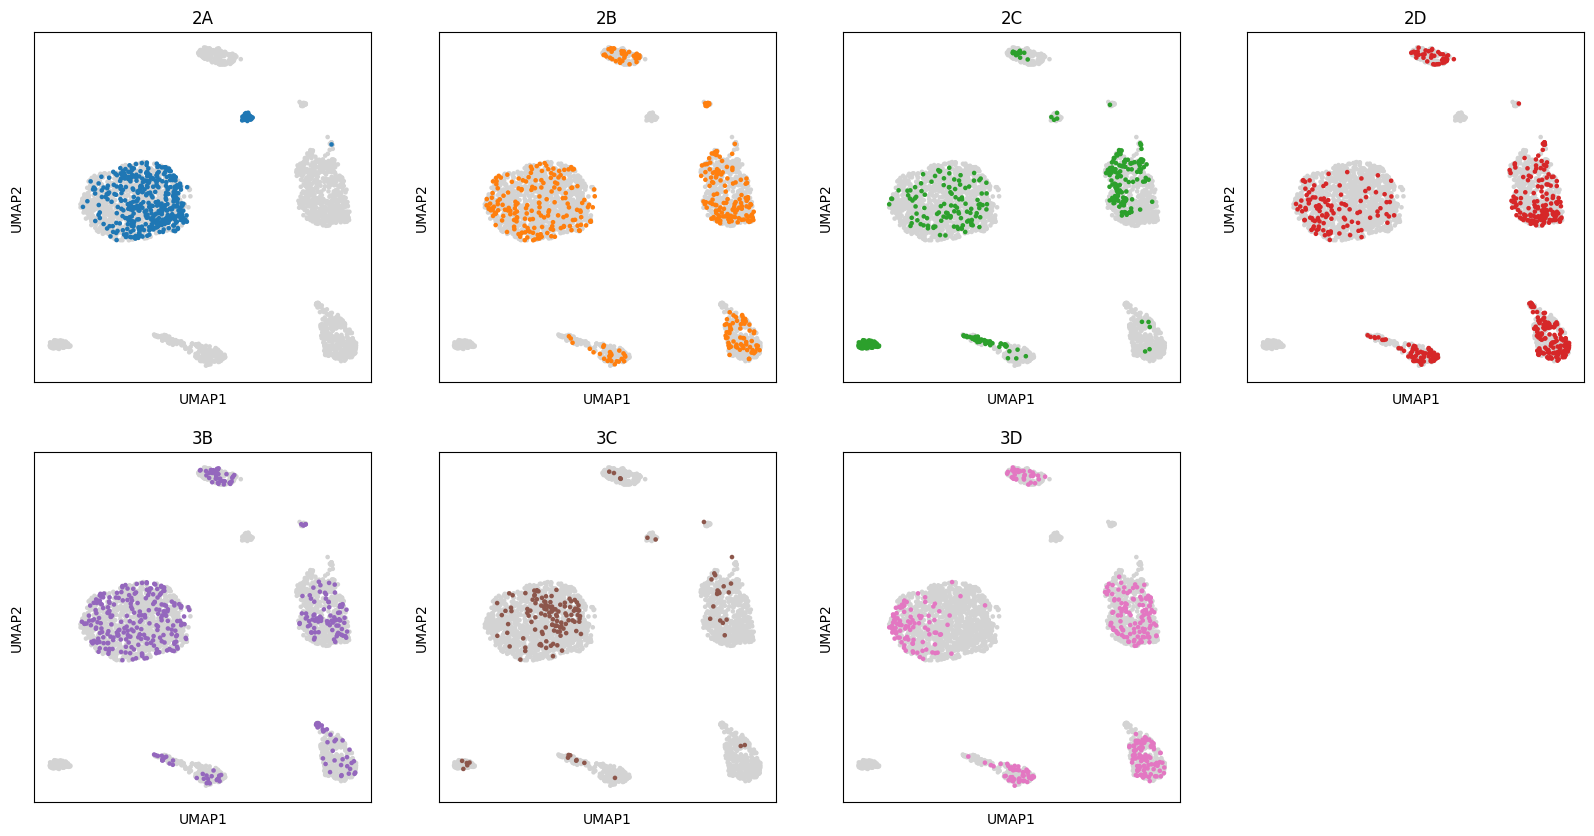

In [18]:
# Plot distribution of samples in umap
pl.plot_group_embeddings(adata, groupby=condition_column, save=figure_path + "sample_distribution_umap.png")

## Cell clustering
- NOTE: resolution: controls the coarseness of the clustering. Higher values lead to more clusters.

Plotting umap for resolution=0.1 (1 / 9)
Plotting umap for resolution=0.2 (2 / 9)
Plotting umap for resolution=0.3 (3 / 9)
Plotting umap for resolution=0.4 (4 / 9)
Plotting umap for resolution=0.5 (5 / 9)
Plotting umap for resolution=0.6 (6 / 9)
Plotting umap for resolution=0.7 (7 / 9)
Plotting umap for resolution=0.8 (8 / 9)
Plotting umap for resolution=0.9 (9 / 9)


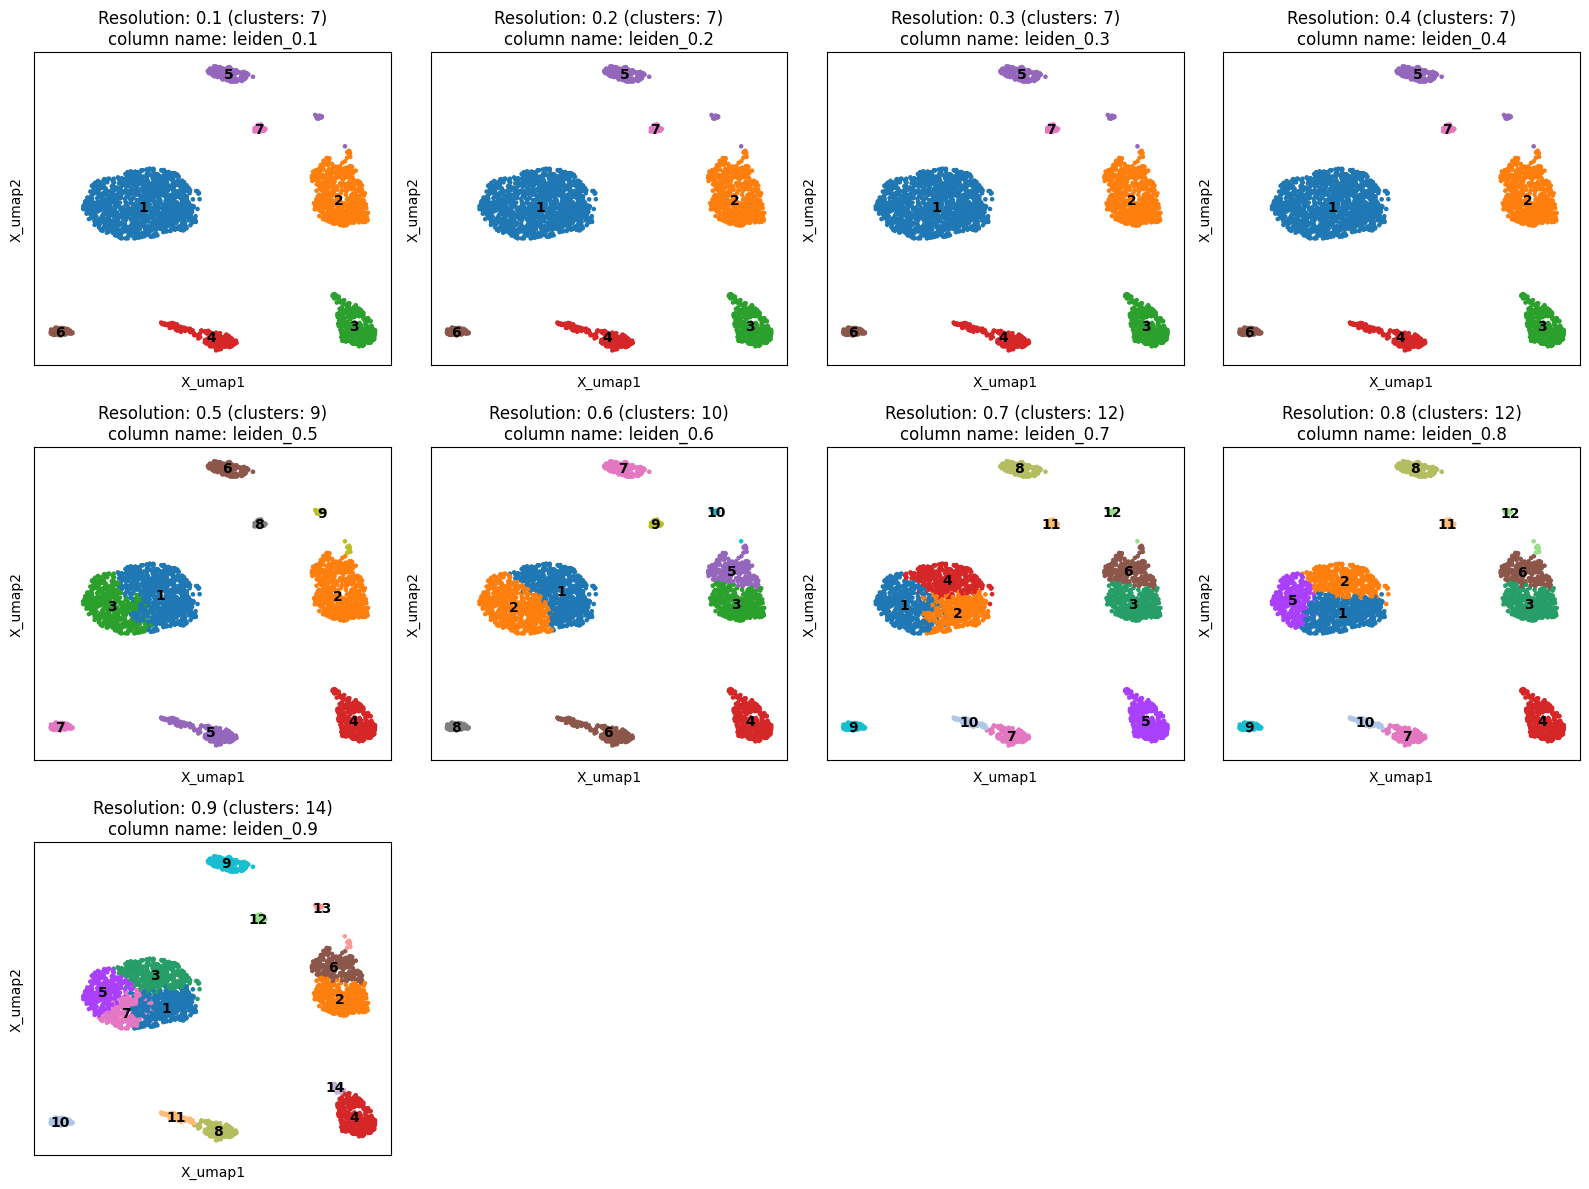

In [19]:
if search_clustering_parameters:
    pl.search_clustering_parameters(adata, ncols=4, method=clustering_method, save=figure_path + "clustering_search.png")

In [4]:
%bgcolor PowderBlue

#Choose final resolution
clustering_column = "leiden_0.5"

### Reclustering

- Based on the last two plots, mainly the heatmap, decide how to make reclusterization.

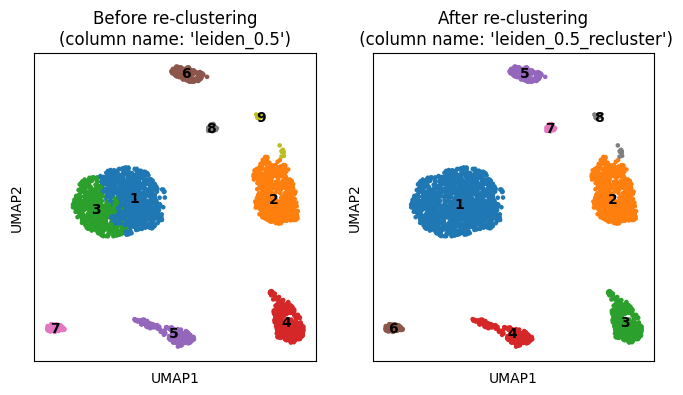

In [21]:
analyser.recluster(adata, clustering_column, ["1", "3"], task="join")
clustering_column = "leiden_0.5_recluster"  #update clustering column

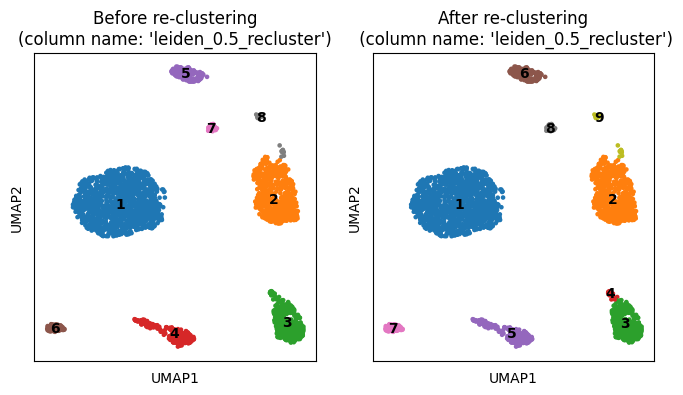

In [22]:
analyser.recluster(adata, clustering_column, ["3"], task="split", resolution=0.15, key_added=clustering_column)  #overwrite column

In [23]:
#Create final clustering
adata.obs["clustering"] = analyser.rename_categories(adata.obs[clustering_column])

### Final clustering

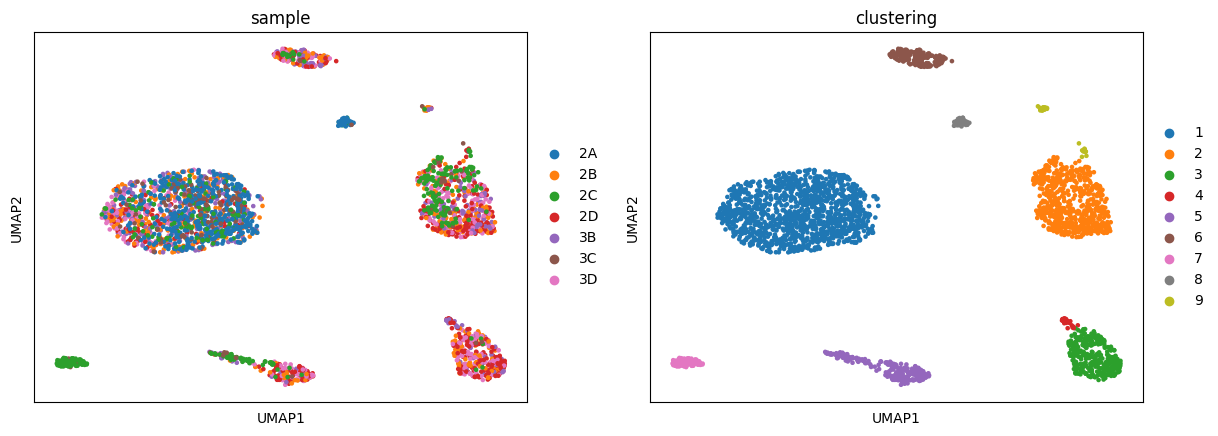

In [24]:
#Plot final leiden
sc.pl.umap(adata, color=[condition_column, "clustering"], show=False)
utils.save_figure(figure_path + "umap_final.pdf")

## Plot distribution of cells across clusters

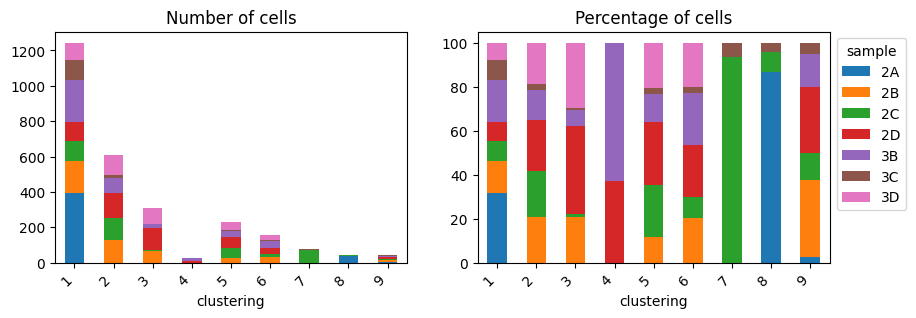

In [25]:
pl.n_cells_barplot(adata, "clustering", groupby=condition_column, 
                   save=figure_path + "cell_distribution_barplot.pdf")

## Saving adata for next notebook

In [26]:
utils.saving_anndata(adata, current_notebook=4)

Your new anndata object is saved here: pipeline_output/results/Test1/anndata_4_Test1.h5ad
